# Домашнее задание к занятию 2.1: Деревья решений. Классификация

## Обзор прошедшего занятия

Что мы делали в классе:

**Задание 1**
* строили деревья
* критерии информативности которых написали даже сами
* визуализировали границы принятия решений в 2d
* и рисовали сами деревья


**Задание 2**
* приняли участие в соревновании на Kaggle, переварив кучу текстовых фичей в численные, проведя кросс-валидацию и сделав сабмит


**Задание 3**
* построили руками несколько метрик качества бинарной классификации


**Задание 4**
* использовали их для оценки классификации разделения статей Ведомостей по топикам

*дополнительно было много приятных ништяков. Например, облако слов, мультипоточность в целях парсинга, удобный инструмент для нахождения правильной css разметки, сохранение моделей в статичные файлы, разделение строк на слова и лемматизация этих слов*

## Домашнее задание

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

**Lvl 2:** (опционально)

* С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC
* Придумать себе интересную задачу на основе данных из интернета =) Спарсить ещё какой-нибудь сайт (не Ведомости) и решить задачу классификации. Делать свои проекты - круто. Если будут - кидайте мне =) [@NikitaKuznetsov](http://t.me/NikitaKuznesov)

In [1]:
import pandas as pd

In [2]:
test=pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
train=pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Группируем по полу и расчитываем кол-во людей в каждом классе в процентном соотношении
train.groupby('Sex')['Pclass'].value_counts(normalize=True)

Sex     Pclass
female  3         0.458599
        1         0.299363
        2         0.242038
male    3         0.601386
        1         0.211438
        2         0.187175
Name: Pclass, dtype: float64

### Обработка данных
чтобы одинаковым образом обработать train и test и не дублировать все операции 2 раза, соединим эти два набора данных в один, не забыв при этом:

1. выкинуть целевую переменную из train

2. проверить на соответствие набора признаков друг другу

3. добавить флаг того, является ли объект тестовым или нет

In [5]:
# Извлекаем target переменные из данных
y_train = train.Survived
train.drop('Survived', axis=1, inplace=True)

In [6]:
# Проверка на сходимость признаков
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [7]:
# Создаем новые столбцы для возможности дальнейшего извлечения train  и test данных

train['is_test'] = 0
test['is_test'] = 1

In [8]:
# Объединяем данные для обработки
df = pd.concat([train, test])

Пол male/female закодируем в 1/0 и удалим переменные, с которыми мы не будем сейчас работать

In [9]:
df["isMale"] = df.Sex.replace({"male": 1, "female":0})
df.drop(["Sex", "Cabin", "Ticket", "Name", "PassengerId"], axis=1, inplace=True)

In [10]:
# Признаки, значения которых составляют небольшой перечислимый набор, закодируем в отдельные столбцы
df_dummies = pd.get_dummies(df, columns=['Pclass', 'Embarked'])
df_dummies.head()

,Age,SibSp,Parch,Fare,is_test,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,0,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,0,0,0,0,1,0,0,1
3,35.0,1,0,53.1000,0,0,1,0,0,0,0,1
4,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


In [11]:
# разделяем данные построчно на тестовую и трейновую выборки, удаляя те строки где в столбце is_test=0 или 1
X_train = df_dummies[df_dummies.is_test==0].drop('is_test', axis=1)
X_test = df_dummies[df_dummies.is_test==1].drop('is_test', axis=1)

In [12]:
columns = X_train.columns
columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'isMale', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

### Заполнение пустых значений

In [13]:
from sklearn.preprocessing import Imputer

In [14]:
# Смотрим значения Nan
df_dummies.isnull().sum()

Age           263
SibSp           0
Parch           0
Fare            1
is_test         0
isMale          0
Pclass_1        0
Pclass_2        0
Pclass_3        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64

In [15]:
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)
imputer.fit(X_train)


C:\Users\89517_000\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [16]:
# Трансформируем матрицу с помощью imputer по стратегии mean. И обратно преобразовываем в таблицу
X_train_imputed = imputer.transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=columns)
X_train_imputed.head(10)

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.000000,1.0,0.0,7.2500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,38.000000,1.0,0.0,71.2833,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,26.000000,0.0,0.0,7.9250,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,35.000000,1.0,0.0,53.1000,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,35.000000,0.0,0.0,8.0500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5,29.699118,0.0,0.0,8.4583,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6,54.000000,0.0,0.0,51.8625,1.0,1.0,0.0,0.0,0.0,0.0,1.0
7,2.000000,3.0,1.0,21.0750,1.0,0.0,0.0,1.0,0.0,0.0,1.0
8,27.000000,0.0,2.0,11.1333,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9,14.000000,1.0,0.0,30.0708,0.0,0.0,1.0,0.0,1.0,0.0,0.0


### Нормировка значений

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
scaler = StandardScaler()
scaler.fit(X_train_imputed)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [19]:
# Нормализуем матрицу.  И обратно преобразовываем в таблицу
X_train_imputed_scaled = scaler.transform(X_train_imputed)
X_train_imputed_scaled = pd.DataFrame(X_train_imputed_scaled, columns=columns)

X_train_imputed_scaled.head()

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,-0.592481,0.432793,-0.473674,-0.502445,0.737695,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
1,0.638789,0.432793,-0.473674,0.786845,-1.355574,1.767767,-0.510152,-1.107926,2.074505,-0.307562,-1.614710
2,-0.284663,-0.474545,-0.473674,-0.488854,-1.355574,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
3,0.407926,0.432793,-0.473674,0.420730,-1.355574,1.767767,-0.510152,-1.107926,-0.482043,-0.307562,0.619306
4,0.407926,-0.474545,-0.473674,-0.486337,0.737695,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306


In [20]:
X_test_imputed_scaled = scaler.transform(imputer.transform(X_test))
X_test_imputed_scaled = pd.DataFrame(X_test_imputed_scaled, columns=columns)
X_test_imputed_scaled.head()

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0.369449,-0.474545,-0.473674,-0.490783,0.737695,-0.565685,-0.510152,0.902587,-0.482043,3.251373,-1.614710
1,1.331378,0.432793,-0.473674,-0.507479,-1.355574,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
2,2.485693,-0.474545,-0.473674,-0.453367,0.737695,-0.565685,1.960202,-1.107926,-0.482043,3.251373,-1.614710
3,-0.207709,-0.474545,-0.473674,-0.474005,0.737695,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
4,-0.592481,0.432793,0.767630,-0.401017,-1.355574,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306


### Обучим решающее дерево, причём применим кросс-валидацию для подбора гиперпараметра глубины дерева

Вид функционала качества: scoring='neg_log_loss'. Выбрана именно эта функция, так как именно она будет оценивать качество на Kaggle

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import numpy as np

In [22]:
depths = np.arange(1,10)
features_num = np.arange(1,12)
grid = {'max_depth': depths, 'max_features': features_num}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='neg_log_loss', cv=5)

In [23]:
%%time
gridsearch.fit(X_train_imputed_scaled, y_train)

Wall time: 5.51 s


C:\Users\89517_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [24]:
gridsearch.best_params_

{'max_depth': 2, 'max_features': 11}

In [25]:
gridsearch.best_score_

-0.47281555625074995

In [26]:
pd.DataFrame(gridsearch.cv_results_).head()

C:\Users\89517_000\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\89517_000\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\89517_000\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\89517_000\Anaconda3\lib\site-packa

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.004800,0.001600,0.002600,0.000800,1,1,"{'max_depth': 1, 'max_features': 1}",-0.723794,-0.649060,-0.660498,...,-0.646041,0.046658,31,-0.603150,-0.604883,-0.652437,-0.632606,-0.633818,-0.625379,0.018814
1,0.003800,0.001166,0.002800,0.000749,1,2,"{'max_depth': 1, 'max_features': 2}",-0.490850,-0.626799,-0.632929,...,-0.598813,0.055960,28,-0.521234,-0.625633,-0.624113,-0.623238,-0.657104,-0.610264,0.046296
2,0.006801,0.005636,0.004600,0.001744,1,3,"{'max_depth': 1, 'max_features': 3}",-0.669108,-0.491912,-0.654057,...,-0.623308,0.066411,29,-0.652376,-0.520943,-0.655556,-0.653194,-0.654500,-0.627314,0.053197
3,0.005200,0.001166,0.003200,0.000401,1,4,"{'max_depth': 1, 'max_features': 4}",-0.490850,-0.491912,-0.652535,...,-0.562351,0.062798,22,-0.521234,-0.520943,-0.652005,-0.621675,-0.617946,-0.586761,0.054907
4,0.003400,0.000490,0.002201,0.000400,1,5,"{'max_depth': 1, 'max_features': 5}",-0.490850,-0.491912,-0.632929,...,-0.554881,0.056410,20,-0.521234,-0.520943,-0.624113,-0.503145,-0.617946,-0.557476,0.052340


In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train_fin, X_val, y_train_fin, y_val = train_test_split(X_train_imputed_scaled, y_train, test_size=0.2)

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [30]:
cs = 10**np.linspace(-3,1,5)
features_num = np.arange(5,11)

In [31]:
grid = {'C': cs}
gridsearch = GridSearchCV(LogisticRegression(), grid, scoring='accuracy', cv=5)

In [32]:
%%time
gridsearch.fit(X_train_fin, y_train_fin)

C:\Users\89517_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\89517_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\89517_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\89517_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\89517_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a

Wall time: 314 ms


C:\Users\89517_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\89517_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\89517_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\89517_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\89517_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [33]:
gridsearch.best_params_

{'C': 0.1}

In [34]:
best_C = gridsearch.best_params_["C"]
best_C

0.1

In [35]:
from sklearn.metrics import accuracy_score

In [36]:
clf = LogisticRegression(C=best_C)

In [37]:
clf.fit(X_train_fin, y_train_fin)

C:\Users\89517_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [38]:
y_val_pred = clf.predict(X_val)

In [39]:
accuracy_score(y_val, y_val_pred)

0.776536312849162

In [40]:
clf.fit(X_train_imputed_scaled, y_train)

C:\Users\89517_000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [41]:
clf.predict_proba(X_test_imputed_scaled)[:10]

array([[0.87122043, 0.12877957],
       [0.63004594, 0.36995406],
       [0.84442941, 0.15557059],
       [0.88731227, 0.11268773],
       [0.44402082, 0.55597918],
       [0.83691507, 0.16308493],
       [0.33409292, 0.66590708],
       [0.76813556, 0.23186444],
       [0.24424208, 0.75575792],
       [0.91289155, 0.08710845]])

In [42]:
predictions = clf.predict(X_test_imputed_scaled)
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [43]:
submussion = 'PassengerId,Survived\n'
submussion += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(test.PassengerId, predictions)])

In [44]:
with open('submission.txt', 'w') as file:
    file.write(submussion)

In [45]:
for col, val in zip(X_train.columns, clf.coef_[0]):
    print("{:30} {:.2f}".format(col, val))

Age                            -0.43
SibSp                          -0.29
Parch                          -0.06
Fare                           0.13
isMale                         -1.17
Pclass_1                       0.43
Pclass_2                       0.09
Pclass_3                       -0.44
Embarked_C                     0.06
Embarked_Q                     0.03
Embarked_S                     -0.13


In [46]:
from sklearn.tree import DecisionTreeClassifier

In [47]:
clf = DecisionTreeClassifier()

In [48]:

clf.fit(X_train_imputed_scaled, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [49]:
from sklearn.tree import export_graphviz


In [50]:
def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

In [51]:
clf = DecisionTreeClassifier(max_depth=2, max_features=10)
clf.fit(X_train_imputed_scaled, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [52]:
txt = get_tree_dot_view(clf, list(X_train_imputed.columns), X_train_imputed.columns)

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="isMale <= -0.309\ngini = 0.473\nsamples = 891\nvalue = [549, 342]\nclass = Age", fillcolor="#e5813960"] ;
1 [label="Pclass_3 <= -0.103\ngini = 0.383\nsamples = 314\nvalue = [81, 233]\nclass = SibSp", fillcolor="#399de5a6"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.1\nsamples = 170\nvalue = [9, 161]\nclass = SibSp", fillcolor="#399de5f1"] ;
1 -> 2 ;
3 [label="gini = 0.5\nsamples = 144\nvalue = [72, 72]\nclass = Age", fillcolor="#e5813900"] ;
1 -> 3 ;
4 [label="Age <= -1.785\ngini = 0.306\nsamples = 577\nvalue = [468, 109]\nclass = Age", fillcolor="#e58139c4"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="gini = 0.444\nsamples = 24\nvalue = [8, 16]\nclass = SibSp", fillcolor="#399de57f"] ;
4 -> 5 ;
6 [label="gini = 0.28\nsamples = 553\nvalue = [460, 93]\nclass = Age", fillcolor="#e58139cb"] ;
4 -> 6 ;
}


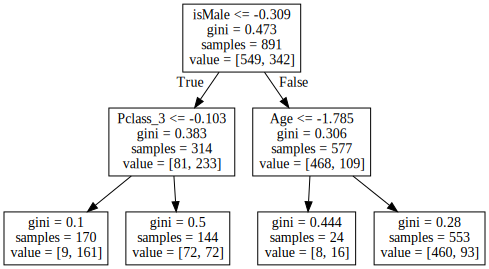

In [67]:
from graphviz import Source

Source( tree.export_graphviz(clf, out_file=None, feature_names=X_train_imputed.columns))